In [256]:
### SIMBAデータベースを通して天体のID　(object name) からその天体が含まれるカタログ情報を返す
from astroquery.simbad import Simbad

result = Simbad.query_object("HIP 105315")
if result is not None:
    print(result)
else:
    print("Star not found in SIMBAD.")

 MAIN_ID        RA           DEC      ...     COO_BIBCODE     SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                                     
--------- ------------- ------------- ... ------------------- ----------------
HD 202990 21 19 48.6389 -14 01 03.059 ... 2020yCat.1350....0G                1


In [259]:
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
import astropy.units as u

# Vizierオブジェクトの設定
v = Vizier(catalog="II/246/out")
v.columns = ['2MASS', 'RAJ2000', 'DEJ2000', 'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag', 'e_Kmag']

# HIP105315の座標を設定（SIMBAD等から取得した正確な座標を使用してください）
coord = SkyCoord("21 19 48.6389 -14 01 03.059", unit=(u.hourangle, u.deg))

#21 19 48.6389026152 -14 01 48.638902688 #<----- STDの座標
#21h 19m 48.64s -14d 01m 03.1s
#319.952644 -14.017561


# クエリの実行
result = v.query_region(coord, radius=5*u.arcsec)

# 結果の表示
if result is not None and len(result) > 0:
    print(result[0])
    print(f"\nJ band magnitude: {result[0]['Jmag'][0]} ± {result[0]['e_Jmag'][0]}")
    print(f"H band magnitude: {result[0]['Hmag'][0]} ± {result[0]['e_Hmag'][0]}")
    print(f"K band magnitude: {result[0]['Kmag'][0]} ± {result[0]['e_Kmag'][0]}")
else:
    print("データが見つかりませんでした。")

     _2MASS       RAJ2000    DEJ2000    Jmag  e_Jmag  Hmag  e_Hmag  Kmag  e_Kmag
                    deg        deg      mag    mag    mag    mag    mag    mag  
---------------- ---------- ---------- ------ ------ ------ ------ ------ ------
21194863-1401032 319.952644 -14.017561  6.875  0.019  6.879  0.049  6.848  0.023

J band magnitude: 6.875 ± 0.01899999938905239
H band magnitude: 6.879000186920166 ± 0.04899999871850014
K band magnitude: 6.8480000495910645 ± 0.023000000044703484


### スペクトルタイプの情報、J,H,K-バンドの測光データ情報から、観測した標準星のスペクトルを推定

In [387]:
from astropy.modeling.models import BlackBody
from astropy import units as u, constants as c
from scipy.constants import h, c, k
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit


In [ ]:
def mag_to_flux(mag, band='J'):
    """
    Vega等級からフラックス[erg/s/cm^2/Å]に変換
    
    Parameters:
    mag: float
        Vega等級
    band: str
        バンド名（デフォルトは'J'）
    
    Returns:
    float: フラックス[erg/s/cm^2/Å]
    """
    # 各バンドのVegaフラックス[erg/s/cm^2/Å]
    vega_flux = {
        'J': 3.01e-10,
        # 必要に応じて他のバンドも追加可能
    }
    
    # フラックスの計算
    flux = vega_flux[band] * 10**(-0.4 * mag)
    
    return flux


9600.0 6.293305914002666e+20


/tmp/ipykernel_2305/216944666.py:57: OptimizeWarning: Covariance of the parameters could not be estimated
  T_eff, scale = curve_fit(fit_function,wave_std,flux_std,p0=[9600,np.max(flux_std)/planck_lam(lam_arr, 9600)[22]])[0]


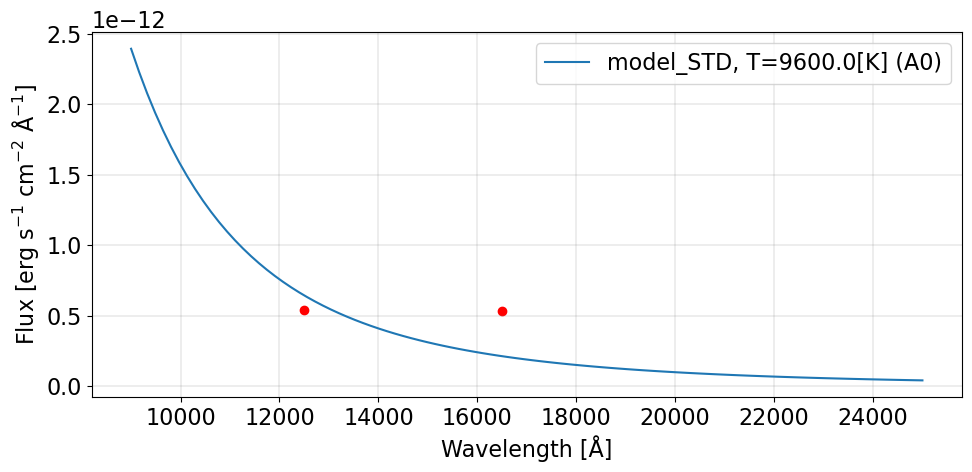

In [389]:
from scipy.optimize import curve_fit


# Physical constants
c = 2.99792458e8    # speed of light [m/s]
h = 6.62606896e-34  # Planck constant [Js]
k = 1.3806504e-23   # Boltzmann constant [J/K]


def planck_lam(lam, T): 
    """
    Calculate black body spectrum
    Args:
        lam: wavelength in meters
        T: temperature in Kelvin
    Returns:
        flux in erg/s/cm^2/Å
    """
    # 基本的なプランク関数 [W/m^3/sr]
    a = 2.0 * h * (c**2) / (lam**5)
    b = 1 / (np.exp(h*c/(k*lam*T)) - 1.0)
    radiance = a * b
    
    # 単位変換の係数
    sr_to_full = np.pi            # srの積分
    w_to_erg = 1e7               # W から erg/s への変換
    m2_to_cm2 = 1e4              # m^2 から cm^2 への変換
    m_to_angstrom = 1e10         # m から Å への変換
    
    # 単位変換の適用
    flux = radiance * sr_to_full * w_to_erg / m2_to_cm2 / m_to_angstrom
    
    return flux

def a0_star_model(wav, T, scale):
    base_spectrum = planck_lam(wav, T)
    return scale * base_spectrum 


####### STD ########
wave_std = np.array([1.25e4, 1.65e4])
arr_mag = [6.87, 6.879]
flux_std = np.array([mag_to_flux(mag)for mag in arr_mag])

####### BB ########

# 温度の設定
T = 9600  # A0型星の温度 [K]
# 波長の配列 (Åンガストロームでプロットするためにmでの計算用)
lam_arr = np.linspace(9e3,2.5e4, 100) # 1000-10000Åの範囲をカバー
#fit_function = planck_lam(lam_arr, T)

####### fitting #######
def fit_function(wav, T, scale):
        return a0_star_model(wav, T, scale)
#curve_fit(fit_function,wave_std,flux_std,p0=[9600,np.max(flux_std)])
T_eff, scale = curve_fit(fit_function,wave_std,flux_std,p0=[9600,np.max(flux_std)/planck_lam(lam_arr, 9600)[22]])[0]
print(T_eff, scale)


# プロットの作成
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)

x = lam_arr
y = scale*planck_lam(lam_arr, T_eff)


# プロット
ax.plot(x, y, label=f"model_STD, T={T_eff}[K] (A0)")  # 波長をÅに変換




ax.scatter(wave_std,flux_std,c='red')

#plt.xlabel(r'$\lambda$ [{0:latex_inline}]'.format(lam.unit))
# plt.ylabel(r"flux$\lambda$:$\mathrm{[10^{-13}erg s^{-1} cm^{-2} Å^{-1}]}$")


# グラフの設定
# ax.set_xscale("log")
# ax.set_yscale("log")
#ax.set_xlim(1e3, 1e4)  # 1000-10000Å
#ax.set_ylim(1e10, 1e15)
ax.set_ylabel("Flux [erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$]")
ax.set_xlabel("Wavelength [Å]")
ax.grid(which="both", color="gray", linewidth=0.2)
ax.legend()
plt.tight_layout()
plt.show()

# ターゲットのスペクトルをSTDスペクトルでわる


## Display target spectrum

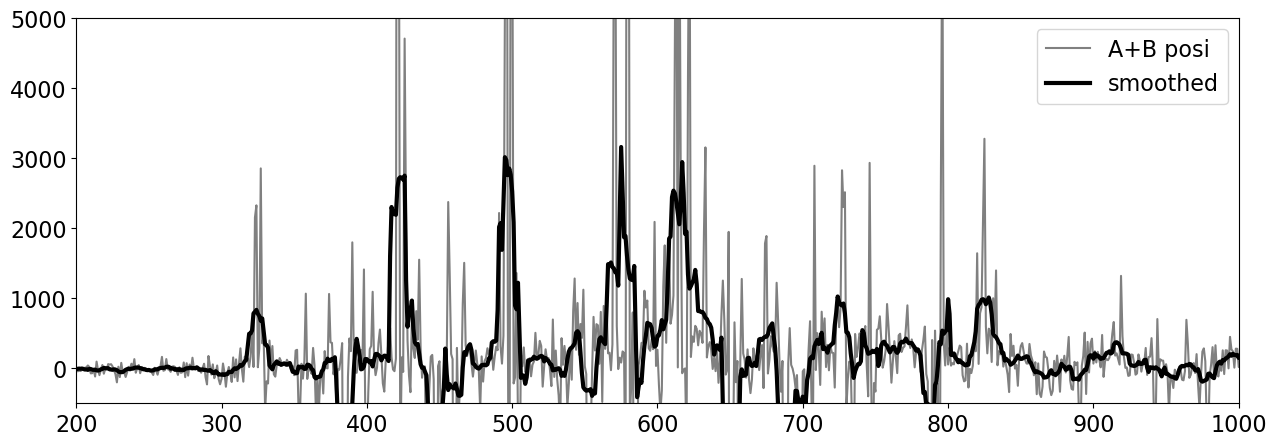

In [413]:
fig = plt.figure(figsize=(15,5), )

plt.plot(spec_oneposi()[0] ,flux_comb,color='gray',label='A+B posi')
plt.plot(spec_oneposi()[0],flux_comb_sm,color='black',lw=3,label='smoothed')
#plt.vlines(1549*(1+5.89),YMIN,YMAX,ls='dashed',lw=5,color='green')
#plt.vlines(13091,YMIN,YMAX,ls='dashed',lw=5,color='green')

#ymin,ymax = np.min(flux_comb),1.2*np.max(flux_comb)
ymin,ymax = -500,5000
plt.xlim(200,1000)
plt.ylim(ymin,ymax)
# plt.text(2000,ymax*0.5,str(objectname[o]),fontsize=20)


plt.legend()

## Display STD spectrum

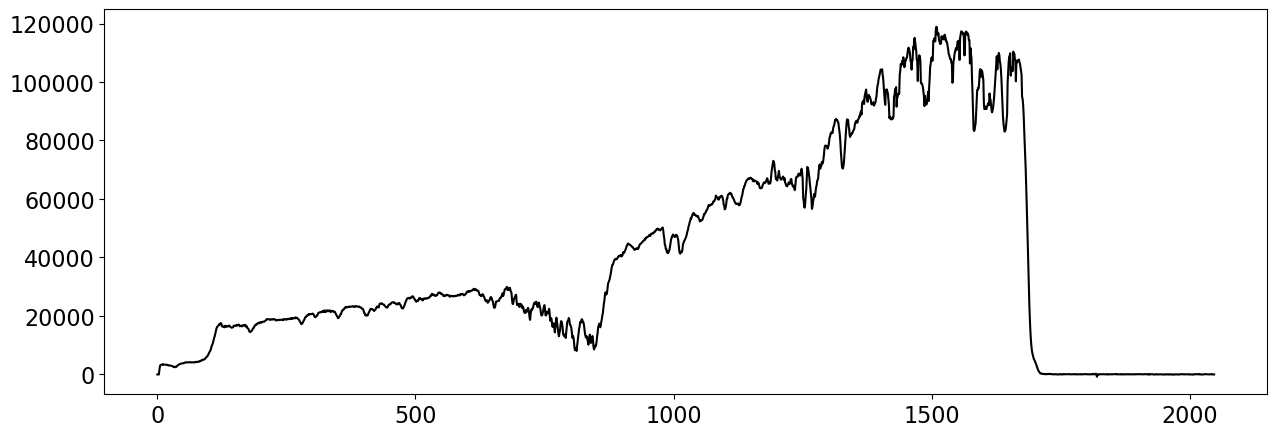

In [448]:
fig = plt.figure(figsize=(15,5), )

plt.plot(lam_std,flux_std_1d,color='black')

## Let's subtract STD spectrum from target spec.

6.293305914002666e+20


Text(0, 0.5, 'Flux$\\lambda$ [erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$]')

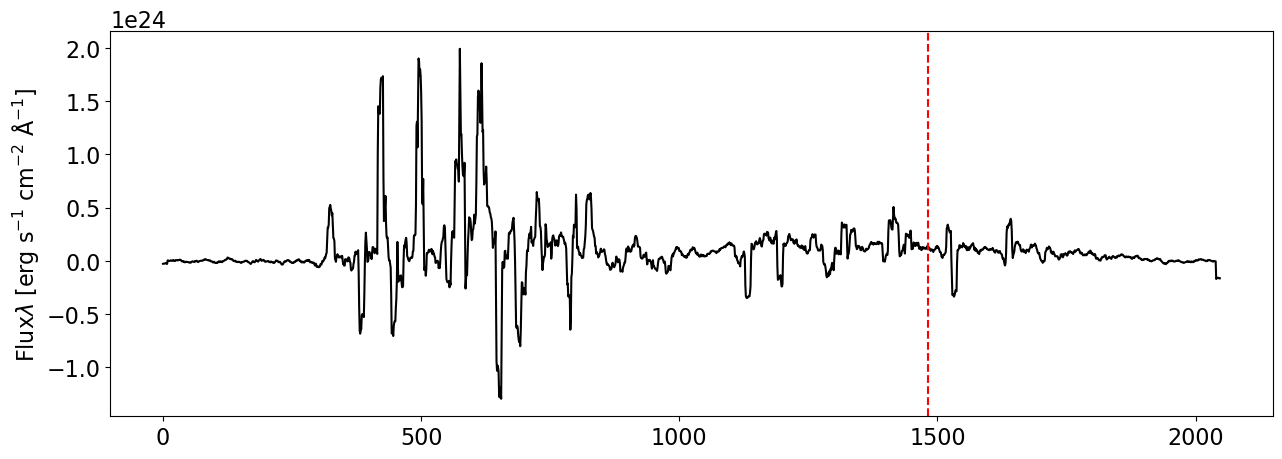

In [520]:
fig = plt.figure(figsize=(15,5), )

lam_target = spec_oneposi()[0]
spec_target = flux_comb_sm
spec_std = flux_std_1d
flux_true =spec_target/spec_std

x = lam_target
y = spec_target*scale
print(scale)
plt.plot(x,y,color='black')
# plt.ylim(-500,900)
#plt.xlim(0,600)

### C IV line
plt.axvline(pix_civ,c='red',ls='dashed')


plt.ylabel(r"Flux$\lambda$ [erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$]")
#lt.xlabel("Wavelength [Å]")

# Convert pixel scale to wavelength 

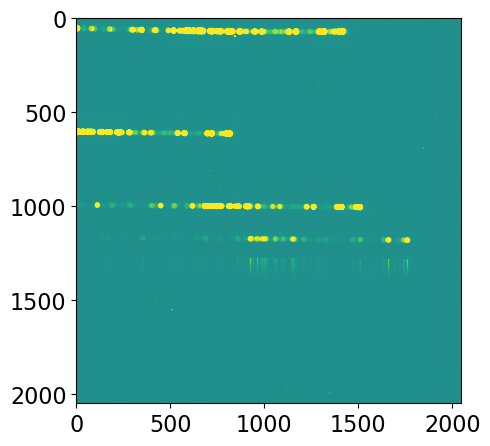

In [419]:
#### Calibration data image
with fits.open(dir_rawdata+"MCSA00294647.fits") as lamp:
    img = lamp[0].data
    #hdu = fits.PrimaryHDU(img_clp[1])
    #hdulist = fits.HDUList([hdu])

fig = plt.figure(figsize=(5,5))
VMIN = np.median(img)-np.std(img)
VMAX = np.median(img)+np.std(img)
plt.imshow(img,vmin = VMIN, vmax=VMAX)

In [451]:
#### このcomparisonデータが検出器1、２のどちらでとられたか確認
file[file['FRAMEID']=='MCSA00294647']

,index,Unnamed: 0,FRAMEID,DATE_OBS,OBJECT,OBS_MODE,DATA_TYP,EXPTIME,DET_ID,SLIT,FILTER_1,FILTER_2,FILTER_3,SEEING,TELESCOP,INSTRUME,AIRMASS,AIRMSTR,AIRMEND,MJD,MJD_STR,MJD_END,UT,UT_STR,UT_END,K_DITCNT
58,58,58,MCSA00294647,2023-08-28,TH-AR,SPEC,INSTFLAT,3.0,1,AT_J2349,HOLE,OC_ZJ,ZJ500,0.0,Subaru,MOIRCS,1.0,1.0,1.0,60184.202256,60184.20223,60184.202282,04:51:14.940,04:51:12.702,04:51:17.177,0


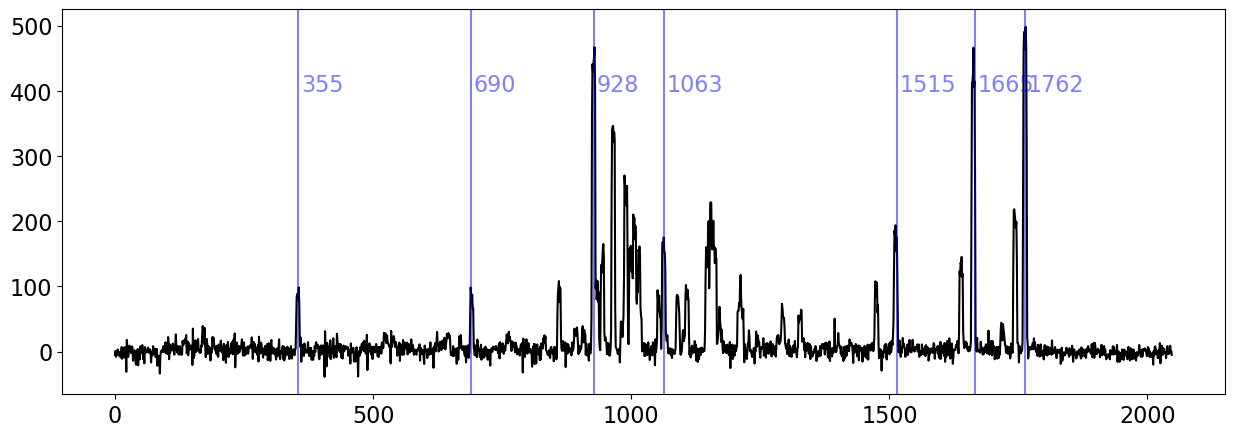

In [444]:
fig= plt.figure(figsize=(15,5))
plt.plot(img[1300,:],color='black')
#plt.ylim(0,)

pix_lamp =[355,690,928,1063,1515,1665,1762]#select by hand
for pix in pix_OH:
    plt.axvline(pix,c='blue',alpha=0.5)
    plt.text(pix+5,400,str(pix),c='blue',alpha=0.5)

